# Laboratorio 10
## Proyecto de Consultoría - SparkML

- Sofia Mishell 22049
- Jose Marchena 22398

### 0) Iniciar Spark

In [1]:
import os

## Para funcionamiento en windows
os.environ["SPARK_LOCAL_DIRS"] = r"C:\tmp\spark-temp"
# (Crear la carpeta en tu equipo si no existe)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Cruceros_Spark").getOrCreate()
print("Spark version:", spark.version)

Spark version: 4.0.1


In [4]:
data_df = spark.read.csv("./barcos_crucero.csv", header=True, inferSchema=True)

In [5]:
data_df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [6]:
data_df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       NULL|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     NULL|       NULL| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

## 1) Analisis Exploratorio

In [7]:
data_df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [ ]:
## Categoricas: Ship Name y Cruise_line
print(data_df.select("Ship_name").distinct().count())
print(data_df.select("Cruise_line").distinct().count())

138
20


Los nombres son casi todos unicos, de las 158 observaciones hay 138 nombres diferentes, lo que significa que solo 20 se repiten mas de una vez. Para la regresion se podria botar esta columna 

In [18]:
from pyspark.sql import functions as F
ship_common_names = data_df.groupBy("Ship_name").count().orderBy(F.desc("count")).limit(6)
ship_common_names.show()     

+---------+-----+
|Ship_name|count|
+---------+-----+
|   Spirit|    4|
|   Legend|    3|
|     Star|    3|
|    Pride|    2|
|     Dawn|    2|
|      Sun|    2|
+---------+-----+



In [20]:
cruise_lines_freq = data_df.groupBy("Cruise_line").count().orderBy(F.desc("count"))
cruise_lines_freq.show() 

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|         Seabourn|    3|
|         Windstar|    3|
|          Oceania|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+



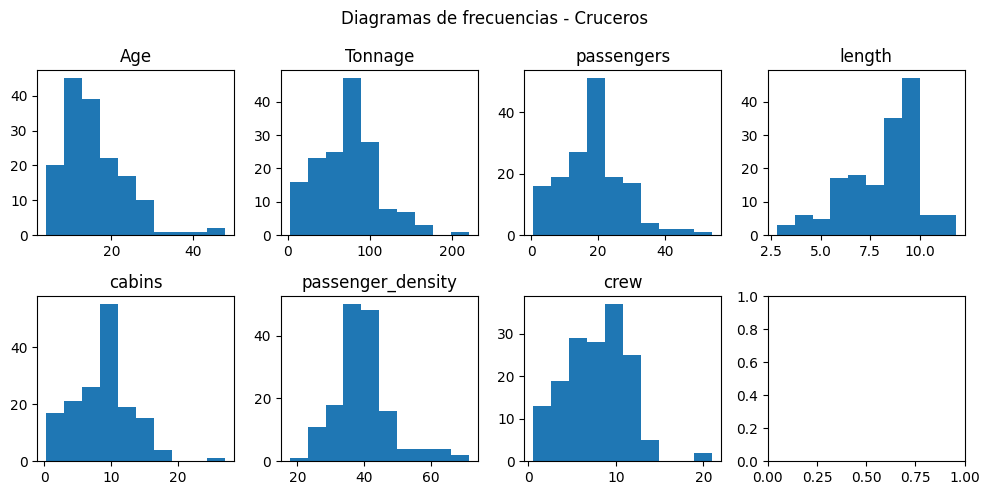

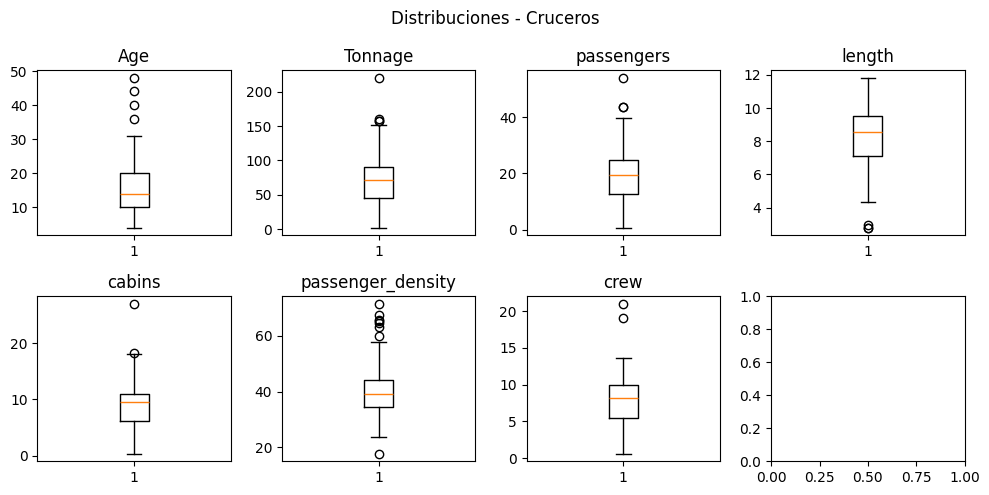

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns

# Columnas numericas
cols =data_df.columns
cols.remove("Ship_name")
cols.remove("Cruise_line")

# Conversion a pandas
pandas_df = data_df.select(cols).toPandas()

# Histogramas
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle("Diagramas de frecuencias - Cruceros")
axes = ax.flatten()
for i, c in enumerate(cols):
    axes[i].set_title(f"{c}")
    axes[i].hist(pandas_df[c])
plt.tight_layout()
plt.show()

# Boxplots
fig, ax = plt.subplots(2,4,figsize=(10,5))
fig.suptitle("Distribuciones - Cruceros")
axes = ax.flatten()
for i, c in enumerate(cols):
    axes[i].set_title(f"{c}")
    axes[i].boxplot(pandas_df[c])
plt.tight_layout()
plt.show()

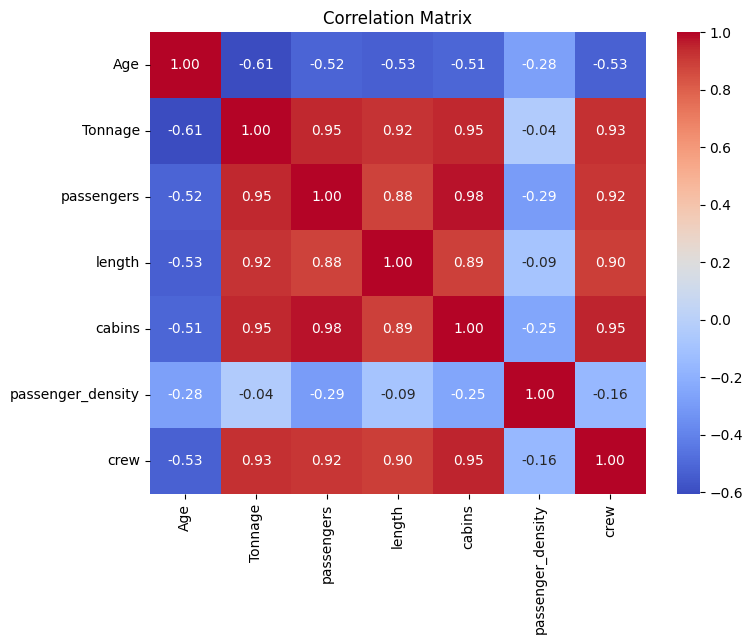

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

cols = data_df.columns
cols.remove("Ship_name")
cols.remove("Cruise_line")

pdf = data_df.select(cols).toPandas()
corr = pdf.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 2) Normalizacion

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

cat_cols = ['Ship_name', 'Cruise_line']
num_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density', 'crew']

In [64]:
# 1 index categoricas
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in cat_cols
]
# 2 OneHotEncoder para categoricas
encoders = [
    OneHotEncoder(
        inputCols=[f"{col}_index"],
        outputCols=[f"{col}_encoded"]
    )
    for col in cat_cols
]
# 3 Standard scaler para numericas
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

## Pipleine
assembler = VectorAssembler(
    inputCols=[f"{col}_encoded" for col in cat_cols] + num_cols,
    outputCol="features_raw"
)
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

## 3) Reg Lineal Inicial

Target -> "Crew"

In [72]:
from pyspark.ml.regression import LinearRegression

train_df_raw, test_df_raw = data_df.randomSplit([0.7, 0.3], seed=67) # ~ six seven ~

pipeline_model = pipeline.fit(train_df_raw)
train_df = pipeline_model.transform(train_df_raw)
test_df= pipeline_model.transform(test_df_raw)

In [ ]:
train_df

In [ ]:
test_df